### Traditional Change Point Detection

In [167]:
import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import warnings


%load_ext autoreload
%autoreload 2
from base import datahandler, evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
challenge_data_dir = Path('dataset/phase_1/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)
label_df = pd.read_csv(labels_dir)

In [148]:
concatenated_dataframes = pd.concat(split_dataframes.values())
# re-arrange columns
cols = concatenated_dataframes.columns.to_list()
cols.remove('ObjectID')
cols.remove('TimeIndex')
cols_ordered = ['ObjectID', 'TimeIndex'] + cols
df = concatenated_dataframes[cols_ordered]

df.reset_index(inplace=True, drop=True)
inputs = df.columns.to_list()
print(inputs)
newvals = np.sin(np.deg2rad(df['True Anomaly (deg)']))
print(newvals.shape)
df.loc['True Anomaly (sin)'] = newvals
inputs = concatenated_dataframes.columns.to_list()
print(inputs)
inputs.remove('ObjectID')
inputs.remove('Timestamp')
inputs.remove('TimeIndex')
inputs.remove('EW')
inputs.remove('EW_Node')
inputs.remove('EW_Node_Location')
inputs.remove('EW_Type')
inputs.remove('NS')
inputs.remove('NS_Node')
inputs.remove('NS_Node_Location')
inputs.remove('NS_Type')
print(len(inputs))

scaled_df = df.copy()
scaled_df[inputs] = StandardScaler().fit_transform(df[inputs].values)


['ObjectID', 'TimeIndex', 'Timestamp', 'Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)', 'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)', 'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)', 'EW', 'EW_Node', 'EW_Type', 'EW_Node_Location', 'NS', 'NS_Node', 'NS_Type', 'NS_Node_Location']
(544860,)


/tmp/ipykernel_23922/3338782481.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc['True Anomaly (sin)'] = newvals


['Timestamp', 'Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)', 'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)', 'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)', 'ObjectID', 'TimeIndex', 'EW', 'EW_Node', 'EW_Type', 'EW_Node_Location', 'NS', 'NS_Node', 'NS_Type', 'NS_Node_Location']
15


[0]
[]


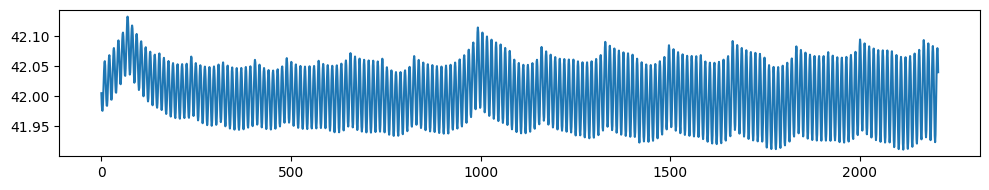

In [205]:
# Detect changepoints using ruptures
def detect_changepoints(df, object_id, features, EW=True, NS=True, plot=False, penalty=500, verbose=1):
    obj_df = df.loc[df['ObjectID'] == object_id]

    # ground truth changepoints
    node_locs = obj_df.loc[((obj_df['EW_Node_Location'] == 1) if EW else False) | ((obj_df['NS_Node_Location'] == 1) if NS else False)][['TimeIndex']]
    gt_node_locations = node_locs['TimeIndex'].to_numpy(dtype=np.int32)
    
    eccentricity = obj_df[features].to_numpy(dtype=np.float32)
    algo = rpt.Binseg(model="l2", min_size=12)
    #algo = rpt.Dynp(model="l2", min_size=15, jump=5)
    algo.fit(eccentricity)
    #predicted_changepoints = algo.predict(n_bkps=4)
    predicted_changepoints = np.asarray(algo.predict(pen=penalty))
    # if a changepoint is predicted at the very end of the sequence, remnove it
    predicted_changepoints = predicted_changepoints[(predicted_changepoints < len(obj_df)-1)]
    # we also know that 0 is always a changepoint ;)
    predicted_changepoints = np.asarray([0]) + predicted_changepoints
    if verbose>0:
        print(f"{gt_node_locations}\n{predicted_changepoints}")

    if plot:
        rpt.display(eccentricity, gt_node_locations, predicted_changepoints)
    return predicted_changepoints

cp = detect_changepoints(df, 68, features=['Longitude (deg)'], EW=True, NS=False, plot=True)

In [209]:
def perform_eval(penalty):
    print("Penalty: ", penalty)
    locs_ew, locs_ns = {}, {}
    objects = list(df["ObjectID"].unique())[:15]
    for obj_id in objects:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore") # disable userwarnings
            locs_ew[int(obj_id)] = detect_changepoints(df, obj_id, features=['Longitude (deg)', 'Eccentricity', 'Altitude (m)'], EW=True, NS=False, plot=False, penalty=penalty, verbose=0)
            locs_ns[int(obj_id)] = detect_changepoints(df, obj_id, features=['Inclination (deg)'], EW=False, NS=True, plot=False, penalty=penalty, verbose=0)

    # Convert the dictionary to a list of tuples
    locs_ew_np = np.vstack([(key, value_item) for key, values in locs_ew.items() for value_item in values])
    locs_ns_np = np.vstack([(key, value_item) for key, values in locs_ns.items() for value_item in values])

    # Convert the list of tuples to a NumPy ndarray
    #result_array = np.concatenate([np.vstack(locs_ew_np), np.vstack(locs_ns_np)])
    result_array = locs_ew_np

    result_df = pd.DataFrame(np.concatenate([result_array.reshape(-1,2)], axis=1), columns=['ObjectID', 'TimeIndex'], dtype=np.int32).sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)

    # Kind of cheating - as we just localized nodes, we assume perfect classifcation
    ground_truth_labels = df[['ObjectID', 'TimeIndex', 'EW_Node', 'EW_Type']].rename(columns={'EW_Node' : 'Node', 'EW_Type' : 'Type'})
    ground_truth_labels['Direction'] = 'EW' # For now just EW, see line above
    ground_truth_labels = ground_truth_labels[(ground_truth_labels['Direction'] == 'EW')]
    mergeDf = result_df.merge(ground_truth_labels, how='left', on = ['ObjectID', 'TimeIndex'])

    # Perform the actual evaluation
    ground_truth_from_file = pd.read_csv(labels_dir).sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
    ground_truth_from_file = ground_truth_from_file[(ground_truth_from_file['Direction'] == 'EW')]
    ground_truth_from_file = ground_truth_from_file[(ground_truth_from_file['ObjectID'].isin(objects))].sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)

    # print(mergeDf.head(10))
    # print(ground_truth_from_file.head(10))

    evaluator = evaluation.NodeDetectionEvaluator(ground_truth_from_file, mergeDf)
    precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F2: {f2:.2f}')
    print(f'RMSE: {rmse:.4}')
    print(f'TP: {total_tp} FP: {total_fp} FN: {total_fn}')



Penalty:  20
Precision: 0.00
Recall: 0.25
F2: 0.01
RMSE: 3.719
TP: 6 FP: 2047 FN: 18
Penalty:  40


ValueError: need at least one array to concatenate

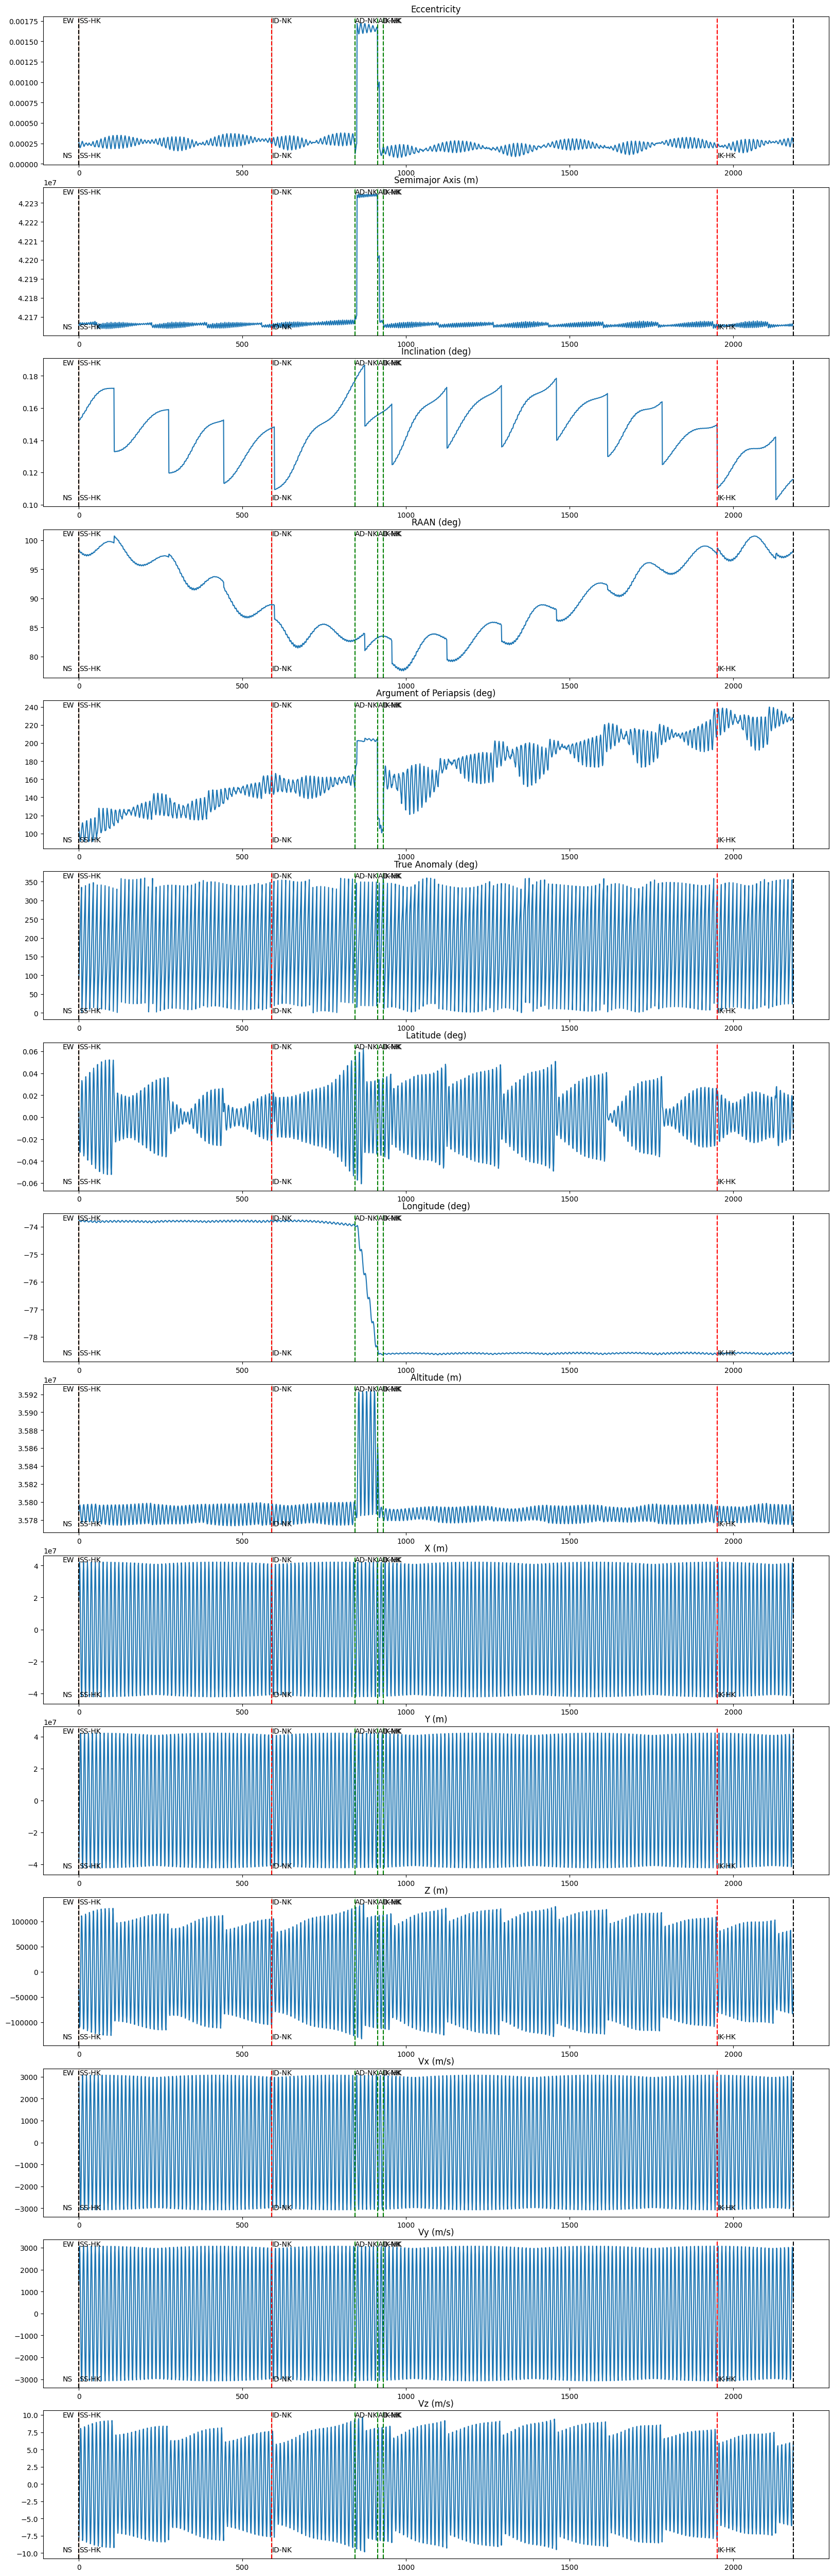

In [137]:
def plot_object(df, labels_df, object_id, past_horizon=10, fut_horizon=10):
    obj_df = df.loc[df['ObjectID'] == object_id]
    labels = labels_df.loc[labels_df['ObjectID'] == object_id]
    fig, axes = plt.subplots(nrows=15, ncols=1, figsize=(16,50))
    plt.tight_layout()
    for ft_idx, input_ft in enumerate(inputs):
        axes[ft_idx].plot(obj_df['TimeIndex'], obj_df[input_ft], label=input_ft)
        axes[ft_idx].text(-50.0,np.min(obj_df[input_ft]),'NS',rotation=0.0)
        axes[ft_idx].text(-50.0,np.max(obj_df[input_ft]),'EW',rotation=0.0)
        for index, row in labels.iterrows():
            if row['Direction'] == 'EW':
                axes[ft_idx].axvline(row['TimeIndex'],color='g', linestyle="--")
                axes[ft_idx].axvspan(row['TimeIndex']-past_horizon, row['TimeIndex']+fut_horizon, alpha=0.2, color='g')
                label=row['Node'] + '-' + row['Type']
                axes[ft_idx].text(row['TimeIndex'] + 1.0,np.max(obj_df[input_ft]),label,rotation=0.0)
            elif row['Direction'] == 'NS':
                axes[ft_idx].axvline(row['TimeIndex'],color='r', linestyle="--")
                axes[ft_idx].axvspan(row['TimeIndex']-past_horizon, row['TimeIndex']+fut_horizon, alpha=0.2, color='r')
                label=row['Node'] + '-' + row['Type']
                axes[ft_idx].text(row['TimeIndex'] + 1.0,np.min(obj_df[input_ft]),label,rotation=0.0)
        axes[ft_idx].axvline(0,color='black', linestyle="--")
        axes[ft_idx].axvline(np.max(obj_df['TimeIndex']),color='black', linestyle="--")
        axes[ft_idx].title.set_text(input_ft)
    plt.show()
plot_object(df, label_df, 214, past_horizon=0, fut_horizon=0)
